In [1]:
import tensorflow as tf

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
os.getcwd()

'/content'

In [6]:
os.listdir('/content')

['.config', 'sample_data']

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
os.getcwd()
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [9]:
data_path = "/content/drive/My Drive/Hands on Deep Learning/mask_dataset_preprocessing" #the path stores preprocessed dataset
os.path.exists(data_path)

True

In [10]:
def DataList(data_path):
  img_list, data_label, data_types = [], [], []
  class_path = ""
  for root, dirs, files in os.walk(data_path): #return a 3-tuple generator
    if root.split("/")[-1]!="model-logs": #split: truncate the path by folders #if last root directory not data_path/model-logs
      for file in files:
        if file.find("checkpoint")==-1: #cannot find substring "checkpoint" in file 
          if file[-3:]=="csv": # file name ends with "csv"
            class_path = os.path.join(root, file)
          else: # file name not ends with "csv"
            img_list.append(os.path.join(root, file))
            label = root.split("/")[-1] # mask_properly, mask_less, mask_improperly
            types = root.split("/")[-2] # test, val, train
            data_label.append(label)
            data_types.append(types)

  data_list = pd.DataFrame({"img_path":img_list, "label_name":data_label, "types":data_types})
  # print(data_list)
  if class_path != "":
    class_map = pd.read_csv(class_path, header=None)
    class_map = dict(class_map.values)
  else:
    class_map = data_list[data_list["types"]=="train"]["label_name"].unique()
    class_map = {label: str(i) for i, label in enumerate(class_map)}
    print(class_map)

  data_list["label"] = data_list["label_name"].map(class_map)
  
  train_list = data_list[data_list["types"]=="train"][["img_path", "label_name", "label"]].copy()
  valid_list = data_list[data_list["types"]=="valid"][["img_path", "label_name", "label"]].copy()
  test_list = data_list[data_list["types"]=="test"][["img_path", "label_name", "label"]].copy()

  return train_list, valid_list, test_list, class_map

In [11]:
train_list, valid_list, test_list, class_map = DataList(data_path)

{'mask_less': '0', 'mask_improperly': '1', 'mask_properly': '2'}


In [12]:
train_list.head()

,img_path,label_name,label
0,/content/drive/My Drive/Hands on Deep Learning...,mask_less,0
1,/content/drive/My Drive/Hands on Deep Learning...,mask_less,0
2,/content/drive/My Drive/Hands on Deep Learning...,mask_less,0
3,/content/drive/My Drive/Hands on Deep Learning...,mask_less,0
4,/content/drive/My Drive/Hands on Deep Learning...,mask_less,0


In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [15]:
num_classes = train_list["label"].unique().shape[0]
num_classes

3

In [16]:
img_shape = (224, 224)
batch_size = 16

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [49]:
train_datagen = ImageDataGenerator(
                    rotation_range=10,
                    horizontal_flip=True,
                    vertical_flip=False,
                    width_shift_range=0.3,
                    height_shift_range=0.3,
                    preprocessing_function=preprocess_input
                    
                    ) # just augment on training data !
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [50]:
train_generator = train_datagen.flow_from_dataframe(
                              dataframe=train_list,
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical')
valid_generator = valid_datagen.flow_from_dataframe(
                              dataframe=valid_list,
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode='categorical',
                              shuffle=False)
test_generator = test_datagen.flow_from_dataframe(
                              dataframe=test_list,
                              directory="",
                              x_col="img_path",
                              y_col="label",
                              target_size=img_shape,
                              batch_size=batch_size,
                              class_mode=None,
                              shuffle=False)

Found 659 validated image filenames belonging to 3 classes.
Found 141 validated image filenames belonging to 3 classes.
Found 141 validated image filenames.


In [51]:
def my_plot(x_data, y_data, batch_size=8):
  plt.figure(figsize=(12,5))
  for i in range(batch_size):
    plt.subplot(2,4,i+1)
    plt.imshow(x_data[i].astype("uint8"))
    plt.title("Label: {}".format(y_data[i],fontsize=16))
    plt.axis('off')
  plt.show()

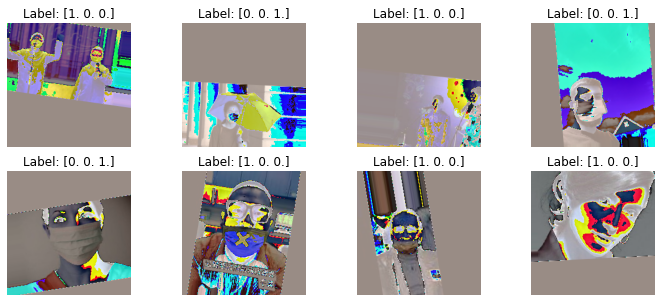

In [52]:
tmp_x, tmp_y = next(train_generator)
my_plot(tmp_x, tmp_y)

In [53]:
tmp_x.min(), tmp_x.max()

(-123.68, 151.061)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


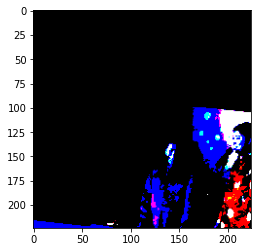

In [54]:
plt.imshow(tmp_x[2])
plt.show()

In [55]:
pre_model = ResNet50(weights='imagenet', input_shape=(img_shape[0], img_shape[1], 3), include_top=False)

x = layers.GlobalAveragePooling2D()(pre_model.output)
x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

In [56]:
model = keras.models.Model(inputs=pre_model.inputs, outputs=outputs)

In [57]:
model_dir = os.path.join(data_path, 'model-logs')
if not os.path.exists(model_dir):
  os.makedirs(model_dir)


modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                      monitor='val_accuracy',
                      save_best_only=True)

earlystop = callbacks.EarlyStopping(monitor='val_loss',
                    patience=3,
                    verbose=1)


callbacks_list = [model_mckp, earlystop]

In [58]:
def num_steps_per_epoch(data_generator, batch_size):
  if data_generator.n % batch_size==0:
    return data_generator.n//batch_size
  else:
    return data_generator.n//batch_size + 1 #cannot be divided => extra batch

In [59]:
lr = 1e-4
batch_size = 16
num_epochs = 10

train_steps = num_steps_per_epoch(train_generator, batch_size)
valid_steps = num_steps_per_epoch(valid_generator, batch_size)

In [60]:
optimizer = keras.optimizers.Adam(lr)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [61]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

First stage of trainning

In [62]:
pre_model.trainable = False
model.summary()

# pre_model.trainable = True
# for each_layer in pre_model.layers[:-5]:
#     each_layer.trainable = False

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [63]:
history = model.fit_generator(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  callbacks=callbacks_list)

Epoch 1/10
42/42 [==============================] - 15s 359ms/step - loss: 0.7136 - accuracy: 0.7086 - val_loss: 0.5034 - val_accuracy: 0.7943
Epoch 2/10
42/42 [==============================] - 12s 282ms/step - loss: 0.3206 - accuracy: 0.8786 - val_loss: 0.9871 - val_accuracy: 0.7589
Epoch 3/10
42/42 [==============================] - 11s 270ms/step - loss: 0.2152 - accuracy: 0.9332 - val_loss: 0.7775 - val_accuracy: 0.7518
Epoch 4/10
42/42 [==============================] - 11s 270ms/step - loss: 0.1406 - accuracy: 0.9499 - val_loss: 1.0704 - val_accuracy: 0.7943
Epoch 00004: early stopping


Second stage of trainning

In [64]:
pre_model.trainable = True
for each_layer in pre_model.layers[:-5]:
    each_layer.trainable = False
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [65]:
history = model.fit_generator(train_generator,
                  steps_per_epoch=train_steps,
                  epochs=num_epochs,
                  validation_data=valid_generator,
                  validation_steps=valid_steps,
                  callbacks=callbacks_list)

Epoch 1/10
42/42 [==============================] - 12s 277ms/step - loss: 0.1309 - accuracy: 0.9514 - val_loss: 1.0501 - val_accuracy: 0.7801
Epoch 2/10
42/42 [==============================] - 11s 274ms/step - loss: 0.1258 - accuracy: 0.9560 - val_loss: 0.8898 - val_accuracy: 0.7730
Epoch 3/10
42/42 [==============================] - 12s 276ms/step - loss: 0.1168 - accuracy: 0.9651 - val_loss: 0.6759 - val_accuracy: 0.7943
Epoch 4/10
42/42 [==============================] - 14s 340ms/step - loss: 0.1418 - accuracy: 0.9590 - val_loss: 0.6728 - val_accuracy: 0.8014
Epoch 5/10
42/42 [==============================] - 12s 285ms/step - loss: 0.0851 - accuracy: 0.9727 - val_loss: 0.9731 - val_accuracy: 0.7872
Epoch 6/10
42/42 [==============================] - 14s 345ms/step - loss: 0.0733 - accuracy: 0.9757 - val_loss: 1.0283 - val_accuracy: 0.8085
Epoch 7/10
42/42 [==============================] - 12s 286ms/step - loss: 0.0647 - accuracy: 0.9818 - val_loss: 1.0362 - val_accuracy: 0.7872

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [67]:
model_path = model_dir + '/{}-last-model.h5'.format('basic_model')
model.save(model_path)

In [68]:
model = keras.models.load_model(model_path)

In [69]:
batch_size = 16
test_steps = num_steps_per_epoch(test_generator, batch_size)

In [70]:
y_test = test_list["label"].values.astype(np.int_)

In [71]:
y_test_predprob = model.predict_generator(test_generator)
y_test_pred = y_test_predprob.argmax(-1)

In [72]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

accuracy_score: 0.809


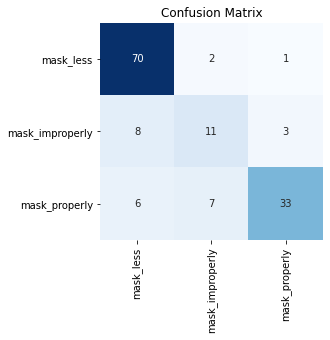

In [73]:
print(f"accuracy_score: {accuracy_score(y_test, y_test_pred):.3f}")

plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
      cmap="Blues", annot=True, fmt="d", cbar=False,
      xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.title("Confusion Matrix")
plt.show()